In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import math
from sklearn import linear_model, decomposition, datasets
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

In [3]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
8190002,THE MAC,FRANKLIN STREET,SWANSTON STREET,VICTORIA STREET,3,6448N,01/06/2012 11:04:22 AM,01/06/2012 11:20:39 AM,977,1P MTR M-SAT 7:30-19:30,0,681,2908
11277756,VICTORIA MARKET,QUEEN STREET,THERRY STREET,FRANKLIN STREET,5,4877W,02/09/2012 01:12:10 PM,02/09/2012 01:40:12 PM,1682,2P SUN 6:00-18:30,0,1171,7617
7580141,THE MAC,ELIZABETH STREET,FRANKLIN STREET,A'BECKETT STREET,2,4388E,14/05/2012 01:40:47 PM,14/05/2012 01:58:30 PM,1063,1P MTR M-SAT 7:30-19:30,0,627,3194
7400681,VICTORIA MARKET,FRANKLIN STREET,QUEEN STREET,ELIZABETH STREET,1,C6620,08/05/2012 06:14:03 PM,08/05/2012 07:08:28 PM,3265,2P MTR M-SAT 7:30-20:30,0,681,2843
9917848,THE MAC,A'BECKETT STREET,ELIZABETH STREET,SWANSTON STREET,4,5985S,23/07/2012 01:51:49 PM,23/07/2012 02:14:49 PM,1380,1P MTR M-SAT 7:30-19:30,0,5,5113


In [4]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [5]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [6]:
#Target field identification
target = parkingdata['Street Name']

unique_vals = target.unique()
target.replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

target.head(10)

8190002     0
11277756    1
7580141     2
7400681     0
9917848     3
3358430     4
1886335     1
10357079    1
3135807     5
7375378     4
Name: Street Name, dtype: int64

In [7]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('Street Name', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('In Violation?', axis = 1, inplace = True)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['In Violation?'] = parkingdata['In Violation?']
features['Side Of Street'] = parkingdata['Side Of Street']
features['Duration of Parking Event (in seconds)'] = parkingdata['Duration of Parking Event (in seconds)']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Between Street 1,Between Street 2,Sign,In Violation?,Side Of Street,Duration of Parking Event (in seconds),Street ID,Device ID,Arrival Hour,Departure Hour
8190002,0,0,0,0,0,3,977,681,2908,11,11
11277756,1,1,1,1,0,5,1682,1171,7617,13,13
7580141,0,2,2,0,0,2,1063,627,3194,13,13
7400681,1,3,3,2,0,1,3265,681,2843,18,19
9917848,0,4,4,0,0,4,1380,5,5113,13,14
3358430,2,5,5,3,1,2,21593,839,892,10,16
1886335,3,6,6,0,0,1,1718,1171,592,13,14
10357079,4,7,7,4,0,1,3000,1171,6068,14,14
3135807,5,8,8,5,0,3,132,597,4570,18,18
7375378,2,9,9,6,1,5,4019,839,815,10,11


In [8]:
#Parameter Tuning
         ####NOTE: random_split=1 for test_train
#Define the parameters to tune and the values to tune to
params_dtc = [
    {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [None,1, 2, 4, 10],
        'max_depth': [None, 4, 10, 15],
        'splitter' : ['best', 'random'],
        'min_samples_split':[None,5, 8, 10, 12, 14, 16]
    }
]

In [9]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_dtc = GridSearchCV(estimator = DecisionTreeClassifier(),
                      param_grid = params_dtc, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [10]:
#Fit the model with the dataset
bestModel = gs_dtc.fit(features, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   32.8s finished


In [11]:
#Find the best values for the  parameters of the model (Standard output)
gs_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'splitter': 'best'}

In [12]:
#Find the best values for the  parameters of the model (Formatted output)
best_criterion = bestModel.best_estimator_.get_params()['criterion']
best_max_depth =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion)
print('Best max_depth: ', best_max_depth )
print('Best min_samples_leaf: ', best_min_samples_leaf )
print('Best min_samples_split: ', best_min_samples_split)
print('Best splitter: ', best_splitter)

Best criterion:  entropy
Best max_depth:  10
Best min_samples_leaf:  2
Best min_samples_split:  5
Best splitter:  best


In [13]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.9846
556,entropy,15.0,10.0,14.0,best,0.9962
557,entropy,15.0,10.0,14.0,random,0.9844
558,entropy,15.0,10.0,16.0,best,0.9962


In [14]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
dtc = metric = DecisionTreeClassifier(criterion = best_criterion, 
                               max_depth = best_max_depth, 
                               min_samples_leaf = best_min_samples_leaf,
                               min_samples_split = best_min_samples_split,
                               splitter = best_splitter,
                               random_state = 0
                               )

In [15]:
# Hill climbing
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = dtc.fit(x_train, y_train)
    cur_Score = dtc.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.36
Score with 2 selected features: 0.6475
Score with 3 selected features: 0.6475
Score with 4 selected features: 0.6485
Score with 5 selected features: 0.851
Score with 6 selected features: 0.9985
Score with 7 selected features: 0.9985
Score with 8 selected features: 0.999

Indexs of the desired features
[2, 3, 4, 6, 0, 7, 10, 8]


In [16]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 2,Sign,In Violation?,Duration of Parking Event (in seconds),Area Name,Street ID,Departure Hour,Device ID
8190002,0,0,0,977,0,681,11,2908
11277756,1,1,0,1682,1,1171,13,7617
7580141,2,0,0,1063,0,627,13,3194
7400681,3,2,0,3265,1,681,19,2843
9917848,4,0,0,1380,0,5,14,5113
3358430,5,3,1,21593,2,839,16,892
1886335,6,0,0,1718,3,1171,14,592
10357079,7,4,0,3000,4,1171,14,6068
3135807,8,5,0,132,5,597,18,4570
7375378,9,6,1,4019,2,839,11,815


In [17]:
bestModel = gs_dtc.fit(features_hc, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2554 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   28.2s finished


In [18]:
gs_dtc.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'splitter': 'random'}

In [19]:
best_criterion_hc = bestModel.best_estimator_.get_params()['criterion']
best_max_depth_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf_hc =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split_hc =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter_hc =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion_hc)
print('Best max_depth: ', best_max_depth_hc )
print('Best min_samples_leaf: ', best_min_samples_leaf_hc )
print('Best min_samples_split: ', best_min_samples_split_hc)
print('Best splitter: ', best_splitter_hc)

Best criterion:  gini
Best max_depth:  None
Best min_samples_leaf:  1
Best min_samples_split:  10
Best splitter:  random


In [20]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.9856
556,entropy,15.0,10.0,14.0,best,0.9962
557,entropy,15.0,10.0,14.0,random,0.9851
558,entropy,15.0,10.0,16.0,best,0.9962


In [21]:
dtc = metric = DecisionTreeClassifier(criterion = best_criterion_hc, 
                               max_depth = best_max_depth_hc, 
                               min_samples_leaf = best_min_samples_leaf_hc,
                               min_samples_split = best_min_samples_split_hc,
                               splitter = best_splitter_hc,
                               random_state = 0
                               )

In [22]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = confusion_matrix(y_test,predicted)
print("Confusion Matrix")
print(cm)

#Printing the numerical result of the confusion matrix
print("\n[Train/test split] score: {:.5f}".format(dtc.score(x_test, y_test)))

print(classification_report(y_test, predicted))

Confusion Matrix
[[275   0   0 ...   0   0   0]
 [  0 389   0 ...   0   0   0]
 [  0   0 236 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0   2]]

[Train/test split] score: 0.99920
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      1.00      1.00       389
           2       1.00      1.00      1.00       236
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       118
           5       0.95      1.00      0.97        35
           6       1.00      1.00      1.00       154
           7       1.00      1.00      1.00       175
           8       1.00      1.00      1.00        55
           9       1.00      1.00      1.00       277
          10       1.00      1.00      1.00       138
          11       1.00      1.00      1.00        16
          12       1.00      1.00      1.00       139

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nDecision Tree mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.99900
[fold 1] score: 0.99850
[fold 2] score: 0.99850
[fold 3] score: 0.99950
[fold 4] score: 0.99750

Decision Tree mean score [5 folds] = 0.9986


In [24]:
#visualise the tree
from sklearn import tree
with open('streetTarget.dot', 'w') as f:
    f = tree.export_graphviz(dtc, out_file=f, feature_names=None, class_names=None, filled=True, rounded=True, special_characters=True)
    



 Accuracy score: 0.99920

 Misclassification Rate: 0.00000

 True Positive Rate: 1.00000

 True Negative Rate: 1.00000

 Precision : 1.00000

 Prevalence : 0.58584

 F score : 1.00000

 False Positive Rate: 0.00000


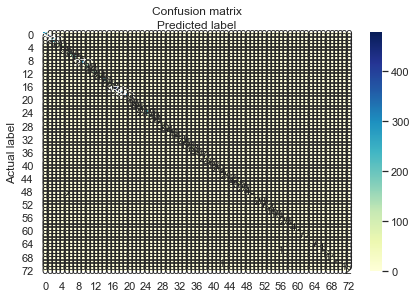

In [25]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Printing the numerical result of the confusion matrix
print("\n Accuracy score: {:.5f}".format(dtc.score(x_test, y_test)))
misclassification_error = (FP + FN) / float(TP + TN + FP + FN)
print("\n Misclassification Rate: {:.5f}".format(misclassification_error))
sensitivity = TP / float(FN + TP)
print("\n True Positive Rate: {:.5f}".format(sensitivity))
specificity = TN / (TN + FP)
print("\n True Negative Rate: {:.5f}".format(specificity))
precision = TP / float(TP + FP)
print("\n Precision : {:.5f}".format(precision))
prevalence =  float(FN + TP)/float(TP + TN + FP + FN)
print("\n Prevalence : {:.5f}".format(prevalence))
fscore = (2 * precision * sensitivity) / (precision + sensitivity)
print("\n F score : {:.5f}".format(fscore))
print("\n False Positive Rate: {:.5f}".format(1-specificity))

In [26]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nKNN mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.99900
[fold 1] score: 0.99850
[fold 2] score: 0.99850
[fold 3] score: 0.99950
[fold 4] score: 0.99750

KNN mean score [5 folds] = 0.9986
